Este notebook dá continuidade à análise dos dados agropecuários, realizando testes de Inferência Estatística e aplicando regras de associação. O objetivo é aprofundar a compreensão das relações entre desmatamento, área plantada e produção agrícola e pecuária, identificando padrões relevantes que possam auxiliar em tomadas de decisão e em estudos ambientais e econômicos.

In [ ]:
#Importação da bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from matplotlib.colors import LinearSegmentedColormap

url = "https://raw.githubusercontent.com/amandacmelo/Projeto-Ciencia-de-Dados/main/dados_limpos.csv"
dados = pd.read_csv(url, sep=",")

#dados = pd.read_csv(url, on_bad_lines="skip", sep=";") #lida com linhas com algum espaço vazio
dados.columns

Index(['Ano', 'CDMunicipio', 'Populacao', 'PessoalOcupado',
       'PessoalAssalariado', 'VrSalarios', 'PIB', 'QtEmpresas',
       'AreaPlantada_h', 'AreaColhida_h', 'VlProducaoAgricola',
       'VlProducaoPecuaria', 'Area', 'Importacoes_US$', 'Exportacoes_US$',
       'Receitas_R$', 'Transferencias_correntes_R$',
       'Transferencias_capital_R$', 'NrNascimentos', 'NrObitosInfantis',
       'povoamento', 'UF', 'Municipio', 'Regiao', 'PIB_PerCapita',
       'Densidade_Populacional', 'Proporcao_PessoalAssalariado',
       'Proporcao_Area_Plantada'],
      dtype='object')

# 🌲 Há evidência de que municípios com maior valor de produção pecuária também apresentam maior PIB?

A produção pecuária representa uma importante fonte de renda para muitos municípios brasileiros, desempenhando papel central em suas economias. Diante disso, é pertinente investigar se há uma relação significativa entre o valor gerado pela produção pecuária e o Produto Interno Bruto (PIB) desses municípios.

Neste contexto, propõe-se uma análise comparativa entre dois grupos de municípios — aqueles com alto valor de produção pecuária e aqueles com baixo valor — com o objetivo de verificar, por meio de inferência estatística, se o PIB difere significativamente entre esses grupos.

Para isso, será aplicado um teste de hipótese estatístico, com as seguintes formulações:

* Hipótese nula (H₀): A média do PIB é igual nos dois grupos.

* Hipótese alternativa (H₁): A média do PIB difere entre os grupos.



## Organização dos dados para análise

Para investigar a relação entre a produção pecuária e o PIB dos municípios, inicialmente foi selcionado apenas as duas variáveis de interesse: o valor da produção pecuária e o PIB municipal.

Em seguida, foi uutlizado os quartis da variável de produção pecuária para segmentar os municípios em grupos distintos. O primeiro quartil (Q1) representa o limite inferior, enquanto o terceiro quartil (Q3) representa o limite superior da distribuição dessa variável.

Sendo assim foi definido dois grupos para comparação:

* Grupo Baixo Valor de Produção Pecuária: municípios com valor de produção pecuária menor ou igual ao primeiro quartil (Q1).

* Grupo Alto Valor de Produção Pecuária: municípios com valor de produção pecuária maior que o terceiro quartil (Q3).

In [ ]:
# Selecionar apenas as colunas necessárias
dados_analise = dados[['VlProducaoPecuaria', 'PIB']].copy()

# Remover linhas com valores ausentes
dados_analise = dados_analise.dropna()

q1 = dados['VlProducaoPecuaria'].quantile(0.25)
q3 = dados['VlProducaoPecuaria'].quantile(0.75)

grupo_baixo = dados[dados['VlProducaoPecuaria'] <= q1]
grupo_alto = dados[dados['VlProducaoPecuaria'] > q3]


## Estatística Descritiva

Abaixo estão as estatísticas descritivas e o cálculo da distância entre médias (em erros padrão combinados) para os dois grupos de municípios.

In [ ]:
import numpy as np

def estatisticas_comparacao(grupo1, grupo2, nome1, nome2):
    n1 = grupo1.size
    media1 = grupo1.mean()
    desvio1 = grupo1.std()
    erro_padrao1 = desvio1 / np.sqrt(n1)

    n2 = grupo2.size
    media2 = grupo2.mean()
    desvio2 = grupo2.std()
    erro_padrao2 = desvio2 / np.sqrt(n2)

    erro_padrao_comb = np.sqrt(erro_padrao1**2 + erro_padrao2**2)

    distancia = abs(media1 - media2) / erro_padrao_comb

    print(f"Estatísticas para {nome1}:")
    print(f"  Tamanho: {n1}")
    print(f"  Média PIB per capita: {media1:.2f}")
    print(f"  Desvio padrão: {desvio1:.2f}")
    print(f"  Erro padrão da média: {erro_padrao1:.2f}\n")

    print(f"Estatísticas para {nome2}:")
    print(f"  Tamanho: {n2}")
    print(f"  Média PIB per capita: {media2:.2f}")
    print(f"  Desvio padrão: {desvio2:.2f}")
    print(f"  Erro padrão da média: {erro_padrao2:.2f}\n")

    print(f"Distância entre as médias (em erros padrão combinados): {distancia:.2f}")

grupo_baixo_pib = grupo_baixo['PIB_PerCapita'].dropna()
grupo_alto_pib = grupo_alto['PIB_PerCapita'].dropna()

estatisticas_comparacao(grupo_baixo_pib, grupo_alto_pib, "Grupo Baixo", "Grupo Alto")


Estatísticas para Grupo Baixo:
  Tamanho: 8336
  Média PIB per capita: 17.36
  Desvio padrão: 25.48
  Erro padrão da média: 0.28

Estatísticas para Grupo Alto:
  Tamanho: 8339
  Média PIB per capita: 23.82
  Desvio padrão: 26.29
  Erro padrão da média: 0.29

Distância entre as médias (em erros padrão combinados): 16.12


### Conclusão

A análise descritiva dos grupos com baixo e alto valor de produção pecuária mostra que o grupo de municípios com produção pecuária alta apresenta uma média de PIB per capita significativamente maior (23,82) em comparação ao grupo com produção pecuária baixa (17,36).

A distância entre as médias, expressa em erros padrão combinados, é bastante elevada (16,12), indicando que essa diferença é estatisticamente relevante e não resultado do acaso.

Além disso, vale destacar que as amostras utilizadas na análise foram cuidadosamente selecionadas a partir dos quartis da variável de produção pecuária, formando dois grupos bem distintos. Cada grupo conta com aproximadamente 8.300 municípios, o que representa um tamanho amostral robusto, conferindo maior confiabilidade estatística aos resultados obtidos


## Verificação de normalidade

Para verificar se a variável PIB nos grupos de municípios com baixa e alta produção pecuária segue uma distribuição normal, foi aplicsdo o [teste de Shapiro-Wilk](https://estatisticafacil.org/glossario/o-que-e-teste-de-shapiro-wilk/).

In [ ]:
from scipy.stats import shapiro
import warnings

warnings.filterwarnings("ignore", message="scipy.stats.shapiro: For N > 5000.*")
# Teste de normalidade para o PIB do grupo com baixa produção pecuária
stat_baixo, p_baixo = shapiro(grupo_baixo_pib)
print("Grupo Baixo Produção Pecuária:")
print(f"  Estatística do teste de Shapiro-Wilk: {stat_baixo:.4f}")
print(f"  P-valor: {p_baixo:.4f}")
print("  → Distribuição NÃO é normal" if p_baixo < 0.05 else "  → Distribuição pode ser considerada normal")
print()

# Teste de normalidade para o PIB do grupo com alta produção pecuária
stat_alto, p_alto = shapiro(grupo_alto_pib)
print("Grupo Alto Produção Pecuária:")
print(f"  Estatística do teste de Shapiro-Wilk: {stat_alto:.4f}")
print(f"  P-valor: {p_alto:.4f}")
print("  → Distribuição NÃO é normal" if p_alto < 0.05 else "  → Distribuição pode ser considerada normal")


Grupo Baixo Produção Pecuária:
  Estatística do teste de Shapiro-Wilk: 0.4945
  P-valor: 0.0000
  → Distribuição NÃO é normal

Grupo Alto Produção Pecuária:
  Estatística do teste de Shapiro-Wilk: 0.6519
  P-valor: 0.0000
  → Distribuição NÃO é normal


### Conclusão
Os resultados do teste de Shapiro-Wilk indicam que as distribuições dos dados para os grupos de Baixa e Alta Produção Pecuária não seguem uma distribuição normal (p-valor < 0,05 em ambos os casos). Por isso, o teste t de Student, que assume normalidade dos dados, não é o mais adequado para comparar esses grupos. Portanto, optou-se pela utilização do teste de Mann-Whitney, que será explicado a seguir.

## Teste de Mann-Whitney U para comparação entre grupos

O [Teste U de Mann-Whitney ](https://www.questionpro.com/blog/pt-br/teste-u-de-mann-whitney=/) é um teste estatístico não paramétrico utilizado para comparar se há diferença significativa entre as distribuições de duas amostras independentes. Ele é especialmente útil quando os dados não seguem uma distribuição normal, como indicado pelo teste de normalidade anteriore.


In [ ]:
from scipy.stats import mannwhitneyu

# Aplicar o teste de Mann-Whitney U
estatistica, p_valor = mannwhitneyu(grupo_baixo_pib, grupo_alto_pib, alternative='two-sided')

# Mostrar os resultados
print("Teste de Mann-Whitney U")
print(f"Estatística do teste: {estatistica:.4f}")
print(f"P-valor: {p_valor:.200f}")

# Conclusão
if p_valor < 0.05:
    print("→ Rejeitamos H0: Há diferença significativa entre os grupos.")
else:
    print("→ Não rejeitamos H0: Não há evidência de diferença entre os grupos.")


Teste de Mann-Whitney U
Estatística do teste: 26240442.0000
P-valor: 0.00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000036675040149946907700030812673498812
→ Rejeitamos H0: Há diferença significativa entre os grupos.


### Conclusão

O teste de Mann-Whitney U foi aplicado para verificar se existe diferença significativa entre os PIBs per capita dos municípios com baixa e alta produção pecuária. O resultado mostrou uma estatística U de 26.240.442,0000 e um p-valor extremamente pequeno (praticamente zero), o que indica uma forte evidência contra a hipótese nula.

Dessa forma, é possível rejeitar a hipótese nula (H₀), concluindo que existe uma diferença estatisticamente significativa no PIB per capita entre os dois grupos de municípios. Isso sugere que o nível de produção pecuária está associado a variações no PIB dos municípios analisados.

# 🌲 Municípios com maior produção agrícola tendem a ter maior área desmatada?

O avanço da agricultura está frequentemente associado a mudanças no uso do solo, incluindo o desmatamento. Diante disso, surge o questionamento: os municípios com maior valor de produção agrícola tendem a apresentar maiores áreas desmatadas? Essa relação pode indicar impactos ambientais significativos ligados à expansão agropecuária.

Esta análise busca compreender essa possível relação, avaliando dados de produção agrícola, área plantada e desmatamento em municípios brasileiros ao longo dos últimos anos, com o objetivo de identificar padrões e associações relevantes.

Para tanto, foi utilizado um dataset externo do projeto PRODES, do qual foram extraídas as seguintes informações:
* ano: representa o ano em que os dados de desmatamento foram registrados;

* id_municipio: código numérico único que identifica cada município brasileiro;

* id_municipio_nome: nome do município correspondente ao código;

* desmatado: área total desmatada registrada no município naquele ano.

In [ ]:
url1 = "https://raw.githubusercontent.com/amandacmelo/Projeto-Ciencia-de-Dados/refs/heads/main/Dados%20sobre%20Desmatamento/area_desmatada_municipio.csv"
dados_desmatamento = pd.read_csv(url1, sep=",")

#dados = pd.read_csv(url, on_bad_lines="skip", sep=";") #lida com linhas com algum espaço vazio
dados_desmatamento.columns

Index(['ano', 'id_municipio', 'id_municipio_nome', 'desmatado'], dtype='object')

## Preparação dos Dados
Para garantir a correta correspondência entre os datasets dados e dados_desmatamento, as colunas ano e id_municipio do dataset de desmatamento foram renomeadas para Ano e CDMunicipio, respectivamente. Essa padronização facilita a união dos dados por meio dos mesmos identificadores.

Em seguida, foram criadas variáveis booleanas para facilitar a aplicação de algoritmos de regras de associação. Essas variáveis indicam se os valores das variáveis originais (desmatado, VlProducaoAgricola, AreaPlantada_h e VlProducaoPecuaria) são considerados "altos", definidos a partir do valor mediano de cada uma delas.

In [ ]:
# Primeiro, renomeia colunas de dados_desmatamento para fazer merge
dados_desmatamento.rename(columns={
    "ano": "Ano",
    "id_municipio": "CDMunicipio"
}, inplace=True)

# Faz o merge
df = pd.merge(dados, dados_desmatamento, on=["CDMunicipio", "Ano"], how="inner")

# Seleciona apenas as colunas de interesse
colunas_uso = [
    "Ano", "CDMunicipio", "Municipio", "Regiao",
    "AreaPlantada_h", "VlProducaoAgricola", "VlProducaoPecuaria",
    "desmatado"
]
df = df[colunas_uso]
df.columns

import pandas as pd

# Criação de colunas booleanas para regras de associação
df['Desmatamento_Alto'] = df['desmatado'] > df['desmatado'].median()
df['Agricultura_Alta'] = df['VlProducaoAgricola'] > df['VlProducaoAgricola'].median()
df['Pecuaria_Alta'] = df['VlProducaoPecuaria'] > df['VlProducaoPecuaria'].median()
df['AreaPlantada_Alta'] = df['AreaPlantada_h'] > df['AreaPlantada_h'].median()

# Selecionar apenas essas colunas para análise
df_apriori = df[['Desmatamento_Alto', 'Agricultura_Alta', 'Pecuaria_Alta', 'AreaPlantada_Alta']]


## Análise Inicial dos dados
Incialmente foi feito uma matriz de correlação entre as variáveis numéricas relacionadas a desmatamento, área plantada e valores de produção agrícola e pecuária. Usando um heatmap com uma paleta de cores que varia do azul (correlação negativa) ao vermelho (correlação positiva), ele destaca visualmente a intensidade e direção das correlações entre essas variáveis, facilitando a identificação de relações fortes ou fracas entre elas.

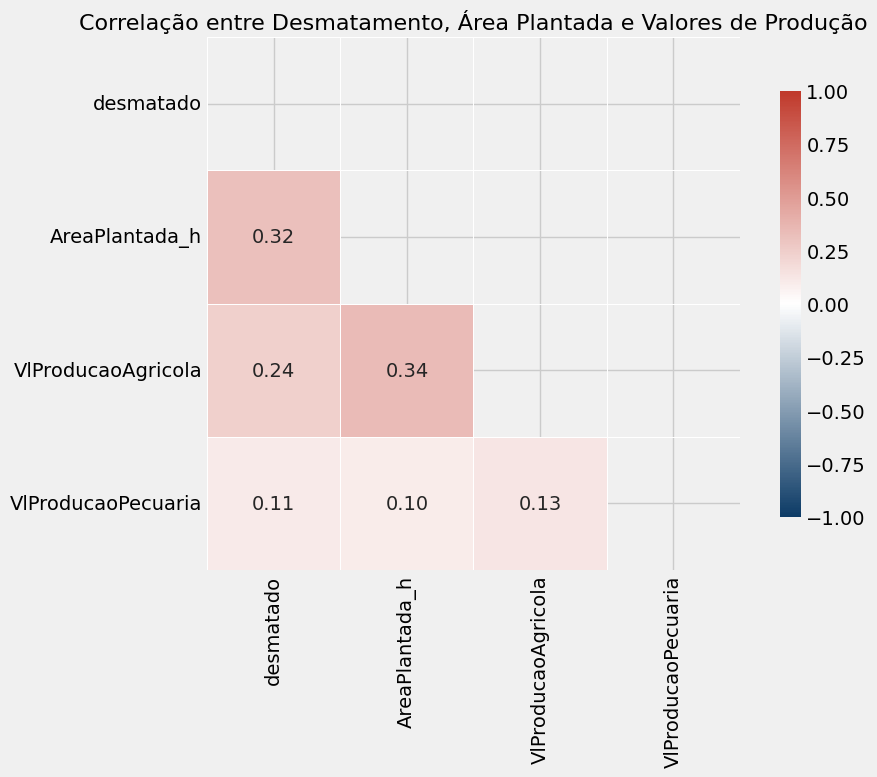

In [ ]:


# Paleta azul para seaborn (para outros gráficos)
cores =  ["#0D3B66", "#145DA0", "#1E81B0", "#2E9CCA", "#69C9D0"]
paleta = sns.color_palette(cores)
sns.set_palette(paleta)
plt.rcParams['figure.figsize'] = (12, 8)
plt.style.use('fivethirtyeight')

# Colunas numéricas para correlação
colunas_numericas = ['desmatado', 'AreaPlantada_h', 'VlProducaoAgricola', 'VlProducaoPecuaria']
correlation = df[colunas_numericas].corr()
mask = np.triu(np.ones_like(correlation, dtype=bool))

# Cria o colormap azul -> branco -> vermelho
cmap_azul_vermelho = LinearSegmentedColormap.from_list(
    "blue_red", ["#0D3B66", "#FFFFFF", "#C0392B"], N=256)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation, mask=mask, cmap=cmap_azul_vermelho, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .8}, annot=True, fmt=".2f")

plt.title('Correlação entre Desmatamento, Área Plantada e Valores de Produção', fontsize=16)
plt.tight_layout()
plt.savefig('correlacao_azul_vermelho.png')
plt.show()


### Conclusão

A matriz de correlação apresentada revela padrões importantes sobre a relação entre desmatamento e diferentes aspectos da produção agropecuária:

* Desmatamento e Agricultura: Existe uma correlação positiva moderada (0,32) entre áreas desmatadas e áreas plantadas, indicando que a expansão agrícola pode estar associada ao desmatamento em proporção significativa.

* Produção Agrícola: A correlação entre desmatamento e valor da produção agrícola (0,24) confirma a relação entre esses fatores, embora em intensidade menor que a relação com a área plantada.

* Pecuária e Desmatamento: Surpreendentemente, a correlação entre desmatamento e valor da produção pecuária é relativamente baixa (0,11), sugerindo que, nos dados analisados, a pecuária tem menor associação direta com o desmatamento do que a agricultura.

* Área Plantada e Produção: Como esperado, existe uma correlação positiva moderada (0,34) entre área plantada e valor da produção agrícola, confirmando a relação entre expansão territorial e aumento da produção.

## Aplicação do Apriori

Neste trecho, foi aplicado o algoritmo Apriori para identificar conjuntos frequentes de variáveis booleanas relacionadas a desmatamento, produção agrícola, pecuária e área plantada, com as seguintes etapas:

* Identificação de conjuntos frequentes: Foi utilizado o Apriori com suporte mínimo de 20%, ou seja, é feito a busca de combinações de variáveis que aparecem em pelo menos 20% dos registros.

* Geração de regras de associação: A partir dos conjuntos frequentes, foi gerado regras que apresentam confiança mínima de 60% (min_threshold=0.6), indicando que a conclusão da regra ocorre em pelo menos 60% dos casos em que a condição é satisfeita.

In [ ]:
from mlxtend.frequent_patterns import apriori, association_rules

# Aplicar Apriori para encontrar itens frequentes
frequentes = apriori(df_apriori, use_colnames=True, min_support=0.2)

# Gerar regras de associação
regras = association_rules(frequentes, metric="confidence", min_threshold=0.6)

# Exibir regras ordenadas por confiança
regras = regras.sort_values(by='confidence', ascending=False)
print(regras[['antecedents', 'consequents', 'support', 'confidence', 'lift']])


                              antecedents          consequents   support  \
6  (Desmatamento_Alto, AreaPlantada_Alta)   (Agricultura_Alta)  0.218967   
4   (Agricultura_Alta, Desmatamento_Alto)  (AreaPlantada_Alta)  0.218967   
3                     (AreaPlantada_Alta)   (Agricultura_Alta)  0.331701   
2                      (Agricultura_Alta)  (AreaPlantada_Alta)  0.331701   
5   (Agricultura_Alta, AreaPlantada_Alta)  (Desmatamento_Alto)  0.218967   
1                     (AreaPlantada_Alta)  (Desmatamento_Alto)  0.284144   
0                      (Agricultura_Alta)  (Desmatamento_Alto)  0.299062   

   confidence      lift  
6    0.770618  1.546284  
4    0.732179  1.547962  
3    0.701278  1.407148  
2    0.665575  1.407148  
5    0.660132  1.320399  
1    0.600733  1.201589  
0    0.600082  1.200286  


### Conclusão

As regras extraídas indicam que existe uma associação positiva e significativa entre os níveis altos de desmatamento, área plantada e produção agrícola. Por exemplo, quando o desmatamento e a área plantada são altos, há uma alta probabilidade (confiança ~77%) de que a produção agrícola também seja alta, com um lift maior que 1,5, indicando uma associação forte e positiva. De forma semelhante, áreas com produção agrícola alta tendem a ter área plantada alta e níveis elevados de desmatamento. Essas relações sugerem que o aumento da produção agrícola e da área plantada está correlacionado com maior desmatamento.